# Eniac

## 1.Importing Data

Turning them into a dictionary of dataframes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates

orders_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orders_clean.parquet"
orderlines_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orderlines_clean.parquet"
products_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/products_clean.parquet"
brands_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/brands_clean.parquet"

# Loading dataframes directly from GitHub
orders_df = pd.read_parquet(orders_url)
orderlines_df = pd.read_parquet(orderlines_url)
products_df = pd.read_parquet(products_url)
brands_df = pd.read_parquet(brands_url)

orders = orders_df.copy()
orderlines = orderlines_df.copy()
products = products_df.copy()
brands = brands_df.copy()

Set Display Formats of Pandas

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 200)

## 2. Data Integration

### 2.1 Mergers and logical combinations

In [3]:
# Rename column to match with orders (better readability)
orderlines.rename(columns={'id_order': 'order_id'}, inplace=True)
orderlines['short'] = orderlines['sku'].str[:3]

In [4]:
oo = orders.merge(orderlines, on='order_id', how='left')
boo = oo.merge(brands, on='short', how='right')

Delete oders where there is one or more products, which are not identified. 
1.make a list of all known products (products table). Go into the orders, orderlines, brands table and exclude orders whose id is not in that list. Lastly merge the products table onto the boo table.

In [5]:
known_products = products['sku']
orders_with_unknown_products = boo.loc[~boo.sku.isin(known_products), "order_id"]
boo = boo.loc[~boo["order_id"].isin(orders_with_unknown_products), :]
df = boo.merge(products, on ='sku', how='left')

### 2.2 Create new columns

#### 2.2.1 Boolean Promotion and Promo_price

Create a boolean condition which is true when a promotion was applied on the price.

In [6]:
df['price_promotion'] = df['unit_price'] < df['price']
df['promo_price'] = df.apply(lambda row: row['unit_price'] if row['price_promotion'] else np.nan, axis=1)
df[['promo_price','price_promotion', 'price']].head()

,promo_price,price_promotion,price
0,23.99,True,35.00
1,23.99,True,35.00
2,23.99,True,35.00
3,23.99,True,35.00
4,23.99,True,35.00


#### 2.2.2 order_price

Use this price to compare to the total paid, to infer knowledge about shipping costs etc.

In [7]:
df['unit_price_total'] = df['product_quantity'] * df['unit_price']
order_total_price = df.groupby('order_id')['unit_price_total'].sum().reset_index()
order_total_price.rename(columns={'unit_price_total': 'order_price'}, inplace=True)
df = df.merge(order_total_price, on='order_id')

#### 2.2.3 Orders with at least one promotional item

In [8]:
df['order_inc_promo'] = df.groupby('order_id')['price_promotion'].transform('any')
df['order_inc_promo'].value_counts()

True     262211
False     15415
Name: order_inc_promo, dtype: int64

#### 2.2.4 Difference between total_paid and order_price

Look at the difference between what was paid and what the products inside the order combined cost. Do this only for completed orders. This might give us insight about promotions on the entire order (10% on your entire oder) or shipping costs. We can also exclude outliers from this, since there might be some corrupted data.

In [9]:
df['diff_paid_totalprice'] = np.where(df['state'] == 'Completed', 
                                     df['total_paid'] - df['order_price'], 
                                     np.nan)

#### 2.2.5 Promotion Percentage per Product

In [10]:
df['promo_perc'] = (1-(df['unit_price']/df['price']))

### 2.3 Outliers

When checking the unit_price, price and total_paid there might be statistically some outliers, but some products are extremely expensive and therefore, should still be utilised. Howeever, there can be some outliers in the difference between what was paid and the value of that order. These should be excluded, since they can show corrupted data. Let's do this here.

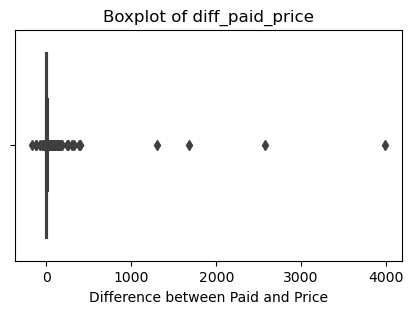

In [11]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['diff_paid_totalprice'])
plt.title('Boxplot of diff_paid_price')
plt.xlabel('Difference between Paid and Price')
plt.show()

In [12]:
Q1 = df['diff_paid_totalprice'].quantile(0.25)
Q3 = df['diff_paid_totalprice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['diff_paid_totalprice'] < lower_bound) | (df['diff_paid_totalprice'] > upper_bound)]
outliers['diff_paid_totalprice'].count()

1097

Let us drop the outliers here.

In [13]:
df = df.loc[~df['diff_paid_totalprice'].isin(outliers['diff_paid_totalprice'])]

Let's see a distributional grpah of the price paid

Only use this code below, when you want to have a copy of the final merged table downloaded.

In [14]:
# from IPython.display import FileLink, FileLinks

# df.to_csv('/Users/merlesteffen/Documents/GitHub/Eniac/Data-Eniac/data.csv', index=False)

In [15]:
df1 = df.reset_index(drop=True).copy()

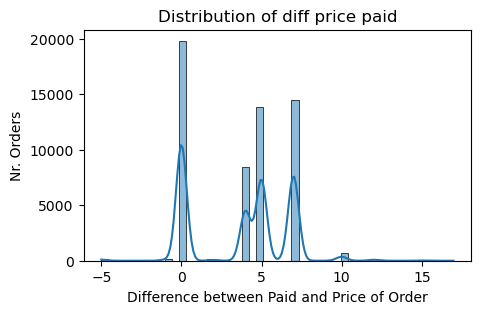

In [16]:
plt.figure(figsize=(5,3))
sns.histplot(df1['diff_paid_totalprice'], bins=50, kde=True)
plt.title('Distribution of diff price paid')
plt.xlabel('Difference between Paid and Price of Order')
plt.ylabel('Nr. Orders')
plt.show()

### 2.4 Second Dataframe, with completed orders

Do this as a laast step so all columns and the cleaning/ merging are the same in both dataframes

In [17]:
df_com = df1.loc[df1['state']=='Completed'].reset_index(drop=True).copy()
df_com.head()

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc
0,347721,2017-04-20 10:22:00,23.99,Completed,1.00,8MO0007,23.99,2017-04-20 10:20:02,8MO,8Mobility,8Mobility iSlice Micro SD adapter for Macbook ...,Micro SD card adapter for MacBook Air 13-inch,35.00,False,12585395,True,23.99,23.99,23.99,True,0.00,0.31
1,347743,2017-04-20 11:28:27,23.99,Completed,1.00,8MO0009,23.99,2017-04-20 11:21:25,8MO,8Mobility,8Mobility iSlice Micro SD Adapter for Macbook ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,True,12585395,True,23.99,23.99,23.99,True,0.00,0.31
2,347761,2017-04-21 08:56:30,66.97,Completed,1.00,8MO0012,23.99,2017-04-20 11:56:42,8MO,8Mobility,8Mobility iSlice Micro SD Adapter MacBook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,66.97,True,0.00,0.31
3,347761,2017-04-21 08:56:30,66.97,Completed,1.00,SAN0140,12.99,2017-04-20 11:56:34,SAN,SanDisk,SanDisk Ultra 32GB microSDHC Memory Card + SD ...,Adapter and microSDHC memory card 32 GB Class ...,12.99,False,57445397,False,NaN,12.99,66.97,True,0.00,0.00
4,347761,2017-04-21 08:56:30,66.97,Completed,1.00,SAN0099,29.99,2017-04-21 08:54:44,SAN,SanDisk,SanDisk Connect Wireless Flash Drive 64GB Wire...,Wireless 64GB storage for iPhone / iPad / Mac.,49.99,True,42945397,True,29.99,29.99,66.97,True,0.00,0.40


## 3. Analysis

Univariate Analysis

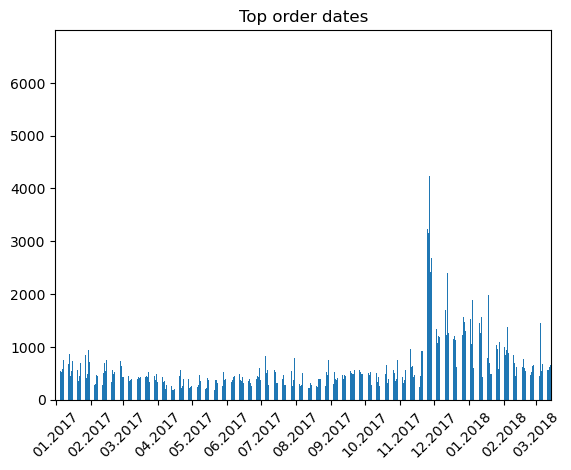

In [63]:
# Plotting the data
ax = df1['created_date'].dt.date.value_counts().sort_index().plot(kind='bar', title='Top order dates')

# Extract the first date of each unique month-year combination
first_dates_of_each_month = df1.drop_duplicates(subset='created_date', keep='first').sort_values('created_date')['created_date'].dt.to_period('M').drop_duplicates().dt.to_timestamp()

# Find the positions of these first dates in the sorted index of the dates from df1
positions = [sorted(df1['created_date'].dt.date.unique()).index(date.date()) for date in first_dates_of_each_month]

# Get the month-year labels for these dates
labels = first_dates_of_each_month.dt.strftime('%m.%Y')

# Set the tick positions and labels
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45)
plt.show()

### 3.1 Analyzing Order Patterns in Relation to Discounts

Objective:
To understand if the introduction or availability of discounts affects order patterns – both in terms of quantity and frequency.

#### 3.1.1 Understand basic metrics

In [18]:
total_orders = df1['order_id'].nunique()
avg_order_value = df1.groupby('order_id')['total_paid'].first().mean()

avg_items_per_order = df1.groupby('order_id').size().mean()
print(f'The total orders are: {total_orders}, the average order values is: {avg_order_value}, and the average items per order are: {avg_items_per_order}')


The total orders are: 195126, the average order values is: 624.4568758135769, and the average items per order are: 1.4171817184793416


Let me check if all total_paid values are the same within each order

In [19]:
unique_paid_counts = df1.groupby('order_id')['total_paid'].nunique()
inconsistent_orders = unique_paid_counts[unique_paid_counts > 1]
if not inconsistent_orders.empty:
    print("There are orders with inconsistent 'total_paid' values:")
    print(inconsistent_orders)
else:
    print("All orders have consistent 'total_paid' values. Therefore I can use the .first() method.")

All orders have consistent 'total_paid' values. Therefore I can use the .first() method.


#### 3.1.2 Compare Metrics

In [20]:
avg_order_value_discounted =(
    df1[df1['order_inc_promo'] == True]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)
avg_order_value_non_discounted =(
    df1[df1['order_inc_promo'] == False]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)

In [21]:
avg_items_discounted =(
    df1[df1['order_inc_promo'] == True]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)
avg_items_non_discounted =(
    df1[df1['order_inc_promo'] == False]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)

In [22]:
print(f'The average order value of discounted orders is: {avg_order_value_discounted}, compared to the average value of non discounted orders: {avg_order_value_non_discounted}\
. Moreover, the average number of items in an order with prmotion is: {avg_items_discounted}, while it is : {avg_items_non_discounted} for non discounted orders.')

The average order value of discounted orders is: 1692.29, compared to the average value of non discounted orders: 391.93. Moreover, the average number of items in an order with prmotion is: 1.61, while it is : 1.23 for non discounted orders.


### 3.2 Temporal Analysis

For now only use completed orders, since otherwise we cannot infer about the promotion.

In [23]:
df1.dtypes

order_id                        object
created_date            datetime64[ns]
total_paid                     float64
state                         category
product_quantity               float64
sku                             object
unit_price                     float64
date                    datetime64[ns]
short                           object
long                            object
name                            object
desc                            object
price                          float64
in_stock                          bool
type                          category
price_promotion                   bool
promo_price                    float64
unit_price_total               float64
order_price                    float64
order_inc_promo                   bool
diff_paid_totalprice           float64
promo_perc                     float64
dtype: object

In [24]:
df1['created_month'] = df1['created_date'].dt.month
monthly_discounted_orders = df1[df1['price_promotion']].groupby('created_month').size()
monthly_discounted_orders

created_month
1     52876
2     31732
3     20855
4      9200
5      8952
6      9122
7     13579
8      9809
9     11127
10    13587
11    39153
12    31376
dtype: int64

### 3.3 Visual Analysis

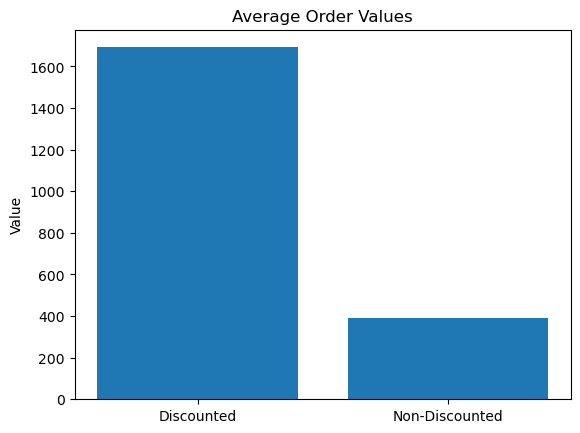

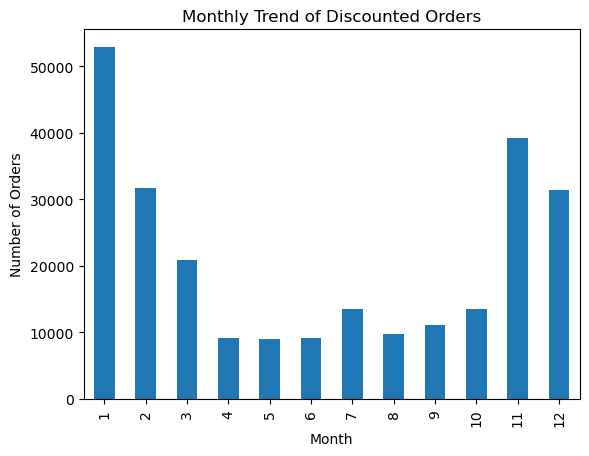

In [25]:
import matplotlib.pyplot as plt

# Average order values comparison
plt.bar(['Discounted', 'Non-Discounted'], [avg_order_value_discounted, avg_order_value_non_discounted])
plt.title('Average Order Values')
plt.ylabel('Value')
plt.show()

# Monthly trends of discounted orders
monthly_discounted_orders.plot(kind='bar')
plt.title('Monthly Trend of Discounted Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Month')
plt.show()


Possible Conclusions:

- If orders with discounts have a significantly higher average value or quantity, it suggests discounts might be driving larger orders.
- If there's a temporal trend showing increased discount orders during specific times, it might suggest seasonal trends or the effects of periodic discount campaigns.

### 3.4 Which Items are bought together

In [26]:
df['grouped'] = df.groupby('order_id')['name'].transform(lambda x: ','.join(x))

In [27]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df['grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))
    
# Print only the first few, since dataframe is too large.
for item, freq in count.most_common(10):
    print(item, freq)

('Apple Magic Trackpad 2', 'Office 365 Personal 1 license 1 M ± or') 21054
('IMac AppleCare Protection Plan', 'Office 365 Personal 1 license 1 M ± or') 17679
('IMac AppleCare Protection Plan', 'Apple Magic Trackpad 2') 14171
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'My MW Case MacBook Pro 13 "(Late 2016) Black') 9521
('My MW Case MacBook Pro 13 "(Late 2016) Black', 'Satechi Hub Multiport USB-C 4K HDMI Space Gray') 4796
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'Satechi Hub Multiport USB-C 4K HDMI Space Gray') 4763
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'Satechi Multiport USB Hub HDMI 4K-C Plata') 4732
('My MW Case MacBook Pro 13 "(Late 2016) Black', 'Satechi Multiport USB Hub HDMI 4K-C Plata') 4724
('Apple Magic Trackpad 2', 'IMac AppleCare Protection Plan') 3538
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'Office 365 Personal 1 license 1 M ± or') 3185


### 3.5 Analyzing Customer Behavior and Retention with Respect to Discounts:

#### 3.5.1 Retention Rate with Respect to Discounts:

To understand if customers acquired during promotional periods are more likely to come back.

In [28]:
df1[['year', 'week', 'day']]= df1['created_date'].dt.isocalendar()
# Extract month and quarter
df1['month'] = df1['created_date'].dt.month
df1['quarter'] = df1['created_date'].dt.quarter

In [29]:
grouped = (
    df1
    .loc[df1['state'] == 'Completed']
    .groupby(['week', 'month', 'quarter', 'year'])
    ['promo_perc']
    .mean()
    .reset_index()
)

grouped

,week,month,quarter,year,promo_perc
0,1,1,1,2017,0.22
1,1,1,1,2018,0.19
2,2,1,1,2017,0.26
3,2,1,1,2018,0.24
4,3,1,1,2017,0.22
...,...,...,...,...,...
71,49,12,4,2017,0.16
72,50,12,4,2017,0.15
73,51,12,4,2017,0.21
74,52,1,1,2016,0.21


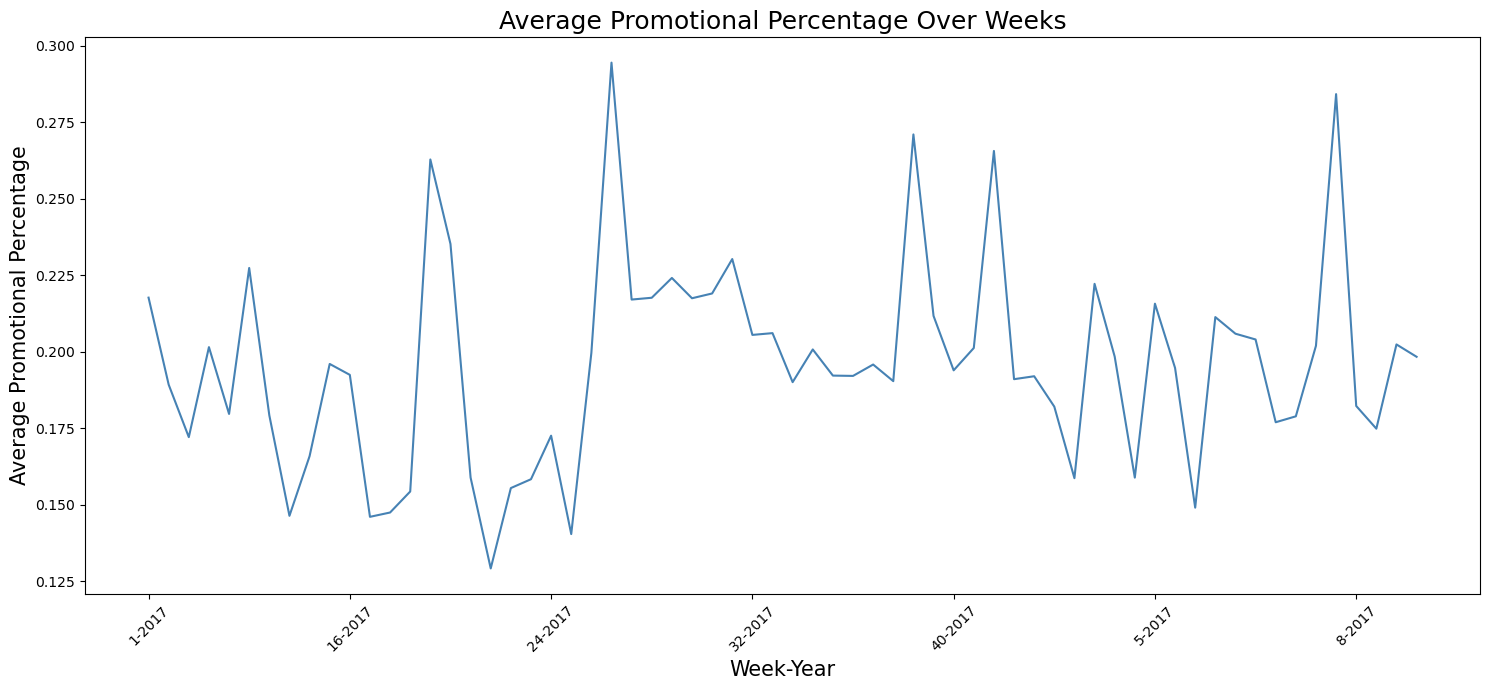

In [30]:
import matplotlib.pyplot as plt

# Creating 'week-year' for plotting
grouped['week-year'] = grouped['week'].astype(str) + '-' + grouped['year'].astype(str)

# Group by 'week-year' and calculate the mean of 'promo_perc'
weekly_promo = grouped.groupby('week-year')['promo_perc'].mean()

# Plot
plt.figure(figsize=(15, 7))
weekly_promo.plot(color='steelblue')
plt.title('Average Promotional Percentage Over Weeks', fontsize=18)
plt.xlabel('Week-Year', fontsize=15)
plt.ylabel('Average Promotional Percentage', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
 grouped =(
     df1
     .loc[df1['state']=='Completed']
     .groupby([df1['created_date'].dt.isocalendar().week, df1['created_date'].dt.month, df1['created_date'].dt.quarter, df1['created_date'].dt.isocalendar().year])
     ['promo_perc']
     .mean()
 )
#grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
print(grouped)

week  created_date  created_date  year
1     1             1             2017   0.22
                                  2018   0.19
2     1             1             2017   0.26
                                  2018   0.24
3     1             1             2017   0.22
                                         ... 
49    12            4             2017   0.16
50    12            4             2017   0.15
51    12            4             2017   0.21
52    1             1             2016   0.21
      12            4             2017   0.20
Name: promo_perc, Length: 76, dtype: float64


Make the Line Plot

look for weeks/months/days where promotion in percentage/ price high. Which one to use?